# Machine Learning Engineer Nanodegree

## Imports and setup

In [1]:
import nltk
nltk.download('wordcloud')

In [2]:
# Print stuff inline
%matplotlib inline

# Imports
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from IPython.display import display
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.naive_bayes import MultinomialNB
from wordcloud import STOPWORDS, WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'wordcloud'

: 

## Helper functions

In [ ]:
# http://stackoverflow.com/questions/33181846/programmatically-convert-pandas-dataframe-to-markdown-table
# This function converts a pandas dataframe to a markdown table.
def pandas_df_to_markdown_table(df):
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    return "|" + df_formatted.to_csv(line_terminator="|\n|", sep="|", index=False)[:-2]

## Read in data

In [3]:
# Load he data and drop columns we don't care about.
try:
    data = pd.read_csv("Amazon_Unlocked_Mobile.csv")
    data.drop(['Product Name', 'Brand Name','Price','Review Votes'], axis = 1, inplace = True)
    print ("{} Amazon mobile phone reviews with {} features each.".format(*data.shape))
except:
    print ("You need to download the dataset from https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones")

411053 Amazon mobile phone reviews with 2 features each.


C:\Users\Deekshitulu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Clean Data

In [4]:
def clean_text(string): 
    # Turn warnings off because BeautifulSoup give some we don't care about
    warnings.filterwarnings('ignore')
    
    # Remove xml formatting.
    review_text = BeautifulSoup(string, "lxml").get_text() 
    
    # Turn warnings back on
    warnings.resetwarnings()
    
    # Remove all characters not in the English alphabet
    string = re.sub("[^a-zA-Z]"," ", string)
    
    # Set all characters to lower case.
    string = string.lower()
    
    return string

In [7]:
# Sometimes people leave ratings without reviews. We are going to ignore empty reviews.
data = data[data['Reviews'].isnull()==False]

# Get the ratings column.
ratings = data['Rating']

# Get the reviews column, and clean the reviews.
reviews = map(clean_text, data['Reviews'])
print(data['Reviews'][0:10])

0    I feel so LUCKY to have found this used (phone...
1    nice phone, nice up grade from my pantach revu...
2                                         Very pleased
3    It works good but it goes slow sometimes but i...
4    Great phone to replace my lost phone. The only...
5    I already had a phone with problems... I know ...
6    The charging port was loose. I got that solder...
7    Phone looks good but wouldn't stay charged, ha...
8    I originally was using the Samsung S2 Galaxy f...
9    It's battery life is great. It's very responsi...
Name: Reviews, dtype: object


## Explore Data

Text(0, 0.5, 'Count')

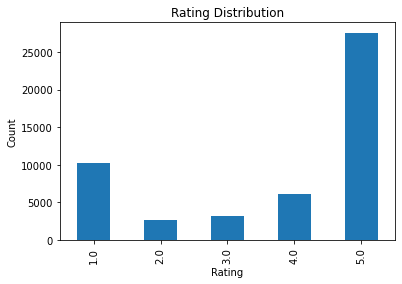

In [5]:

warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

# Create and print a rating distribution graph.
rating_distribution_plt = data.groupby(['Rating']).count().plot(kind='bar', legend=None, title="Rating Distribution")
rating_distribution_plt.set_xlabel("Rating")
rating_distribution_plt.set_ylabel("Count")

Text(0, 0.5, 'Count')

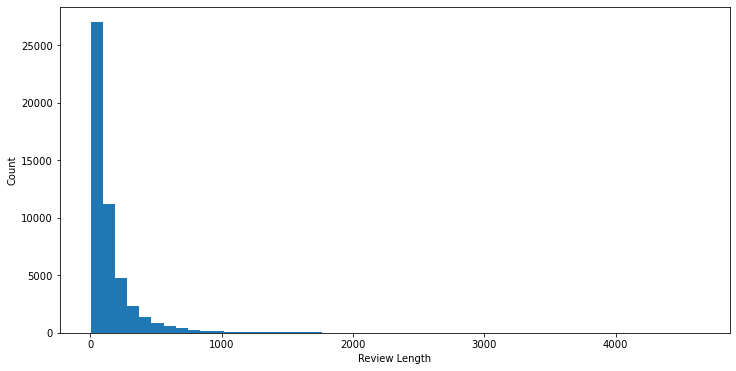

In [9]:
# Create and print a Reviews length distribution graph.
review_length_distribution_plt = pd.DataFrame(data["Reviews"].str.len())
review_length_distribution_plt = review_length_distribution_plt[review_length_distribution_plt.Reviews < 5000]
review_length_distribution_plt.groupby(["Reviews"])
review_length_distribution_plt = review_length_distribution_plt.plot(kind='hist', 
                                                                     legend=None, 
                                                                     bins=50, 
                                                                     figsize=(12, 6))
review_length_distribution_plt.set_xlabel("Review Length")
review_length_distribution_plt.set_ylabel("Count")


## Feature Extraction

In [10]:
vectorizer = TfidfVectorizer(
        min_df=2,               # Ignore phrases that are in fewer than 2 reviews
        max_df=0.95,            # Ignore phrases that are in 95% of reviews
        ngram_range = (1,4),    # Take phrases between 1 and 4 words
        stop_words = 'english', # Remove common English words
        # max_features = 300    # The max features amount of features. Set this to 
                                # something small when getting most relevant phrases to 
                                # prevent crases (We have to do some array conversions which 
                                # take a lot of memory)
        )

# Extract features from reviews.
review_features = vectorizer.fit_transform(reviews)

### Get most relevant  phrases

In [11]:
def get_most_relevant_phrases():
    # Convert features into an array
    feature_array = np.array(vectorizer.get_feature_names()) 
    
    # Sort features by weight.
    tfidf_sorting = np.argsort(review_features.toarray()).flatten()[::-1]
    
    # Get the top eight most weighted features.
    top_n = feature_array[tfidf_sorting][:8]
    return top_n

In [12]:
# It's important not to run this unless you set max_features in TfidfVectorizer to something small. 
# The array conversions can take a lot of memory.
# print get_most_relevant_phrases()

## Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                            review_features,   # The features we created from the reviews
                                            ratings,           # The ratings we are trying to predict
                                            stratify=ratings,  # We have an imbalance of 5-star reviews, so let's stratify
                                            random_state = 12, # Random seed
                                            test_size = 0.3    # We need to save 30% of the data for testing
                                            )
print( X_train.shape)

### Benchmark model

For the benchmark, we are not going to do any parameter tuning; we are going to use sklearns default parameters. As we will see, logistic regression does fairly well right out of the box.

In [ ]:
clf_benchmark = LogisticRegression(random_state=22).fit(X_train, y_train)
example_review_set = pd.DataFrame(y_test[191:197].index).join(data, on=0)
print (pandas_df_to_markdown_table(example_review_set[['Rating','Reviews']]))
#reviewsq = map(clean_text, data['Reviews'][0:10])
#inputereview = vectorizer.fit_transform(reviewsq)

#print(clf_benchmark.predict(inputereview))
#print( classification_report(y_test, clf_benchmark.predict(X_test), digits=4))

### Other models 

Create an unoptimized MultinomialNB classifier.

In [ ]:
clf_NB = MultinomialNB()
clf_NB.fit(X_train, y_train)
print( classification_report(y_test, clf_NB.predict(X_test), digits=4))

Create an unoptimized SGDClassifier classifier.

In [1]:
clf_SGD = SGDClassifier(random_state=22)
clf_SGD.fit(X_train, y_train)
print( classification_report(y_test, clf_SGD.predict(X_test), digits=4))

NameError: name 'SGDClassifier' is not defined

### Refinement 

The alpha paramter determines what value we give the when we see a feature that we haven’t encountered in the testing data. We can’t use 0 because MultinomialNB multiplies these probabilities together and our whole prediction becomes 0. For example, if we find a 5-star review with a single word that we’ve never seen in a 5-star review before we don’t want our prediction to be 0.